In [1]:
# Data
import numpy as np
import pandas as pd

# NLP
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Modeling
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, classification_report, confusion_matrix
from sklearn.utils import shuffle
from sklearn import svm

# plot
import matplotlib.pyplot as plt

ps = PorterStemmer()
stopwords_english = set(stopwords.words('english'))

# 1. Load Data

In [2]:
# load news articles
Path = "C:/Users/Winnie/Documents/2020 Spring/NLP/Final Project/Data/All_Candidates/"
Biden = pd.read_csv(Path + 'Joe_Biden.csv')
Sanders = pd.read_csv(Path + 'Bernie_Sanders.csv')
Trump = pd.read_csv(Path + 'Donald_Trump.csv')

In [3]:
# select text and news company names
Biden_news = Biden[['text', 'media']]
Sanders_news = Sanders[['text', 'media']]
Trump_news = Trump[['text', 'media']]

In [4]:
Biden_news.head(2)

,text,media
0,Hide highlightingFull TextTranslateUndo Transl...,New York Times
1,Hide highlightingAbstractTranslateUndo Transla...,New York Times


In [5]:
# define a function to create corpus for each news companies (NYT, TWP, and WSJ)

def create_corpus(Biden_news, Sanders_news, Trump_news, media_name):
    
    df1 = Biden_news.loc[Biden_news['media'] == media_name]
    df2 = Sanders_news.loc[Sanders_news['media'] == media_name]
    df3 = Trump_news.loc[Trump_news['media'] == media_name]
    frames = [df1, df2, df3]
    df = pd.concat(frames, ignore_index = True)
    
    return df
    

In [6]:
# create small corpus for each news company
NYT = create_corpus(Biden_news, Sanders_news, Trump_news, media_name = 'New York Times')
WSJ = create_corpus(Biden_news, Sanders_news, Trump_news, media_name = 'Wall Street Journal')
TWP = create_corpus(Biden_news, Sanders_news, Trump_news, media_name = 'The Washington Post')

In [7]:
# create large corpus for all 
corpus_All_Medias = pd.concat([NYT, WSJ, TWP], axis = 0, ignore_index = True)
corpus_All_Medias.head()

,text,media
0,Hide highlightingFull TextTranslateUndo Transl...,New York Times
1,Hide highlightingAbstractTranslateUndo Transla...,New York Times
2,Hide highlightingFull TextTranslateUndo Transl...,New York Times
3,Hide highlightingFull TextTranslateUndo Transl...,New York Times
4,Hide highlightingFull TextTranslateUndo Transl...,New York Times


In [8]:
corpus_All_Medias.iloc[1]['text']

'Hide highlightingAbstractTranslateUndo Translation FromToTranslateTranslation in progress... \r\n\r\n[[missing key: loadingAnimation]]The full text may take 40-120 seconds to translate; larger documents may take longer.\r\n\r\nCancel\r\nOverlayEndA new study, which found that Americans were reluctant to use the word â€œsheâ€� to describe a hypothetical president, highlights the sneaky ways language illuminates bias.You have requested "on-the-fly" machine translation of selected content from our databases. This functionality is provided solely for your convenience and is in no way intended to replace human translation. Show full disclaimerNeither ProQuest nor its licensors make any representations or warranties with respect to the translations. The translations are automatically generated "AS IS" and "AS AVAILABLE" and are not retained in our systems. PROQUEST AND ITS LICENSORS SPECIFICALLY DISCLAIM ANY AND ALL EXPRESS OR IMPLIED WARRANTIES, INCLUDING WITHOUT LIMITATION, ANY WARRANTIES

# 2. Data Pre-processing

In [16]:
def Data_Preprocessing(corpus):
    # convert string to list i.e. ['hide', 'highlightingfull', '[[missing']
    corpus['text'] = corpus['text'].str.split()

    # lower case each item in the list, and remove non-alphabetic characters i.e. ['hide', 'highlightingfull', 'missing']
    corpus['text'] = corpus['text'].apply(lambda x: [re.sub(r'[^a-zA-Z]', "",y.lower()) for y in x])

    # join the item in the list back to a string and replace keywords containing the target names
    keywords = ['new york times', 'the new york times', 'international new york times'
                "the washington post", "WP Company LLC", "washpostcom",
                'wall street journal', 'thomaswsjcom', 'Dow Jones Company Inc.']
    corpus['text'] = corpus['text'].apply(lambda x: [' '.join(x).replace(keyword, "") for keyword in keywords])

    # stem each word in the text
    corpus['text'] = corpus['text'].apply(lambda x: str(x[0]))
    corpus['text'] = corpus['text'].str.split()
    corpus['text'] = corpus['text'].apply(lambda x: [ps.stem(y) for y in x])

    # join the item in the list back to a string
    corpus['text'] = corpus['text'].apply(lambda x: [' '.join(x)])

    # convert list to a string
    corpus['text'] = corpus['text'].apply(lambda x: str(x[0]))

    print(type(corpus.iloc[0]['text']))
    
    return corpus

In [17]:
processed_corpus = Data_Preprocessing(corpus_All_Medias)
processed_corpus.head(2)

<class 'str'>


,text,media
0,hide highlightingful texttranslateundo transla...,New York Times
1,hide highlightingabstracttranslateundo transla...,New York Times


In [18]:
# # checking
processed_corpus.to_csv('processed_corpus.csv', index = False)

# 3. Modeling

## 3.1 Split training and test sets 

In [19]:
# separate features and targets
X = processed_corpus.iloc[:, 0]
y = processed_corpus.iloc[:, 1]

# split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)
X_train, y_train = shuffle(X_train, y_train)

X_train.head(2)

973    hide highlightingful texttranslateundo transla...
552    hide highlightingful texttranslateundo transla...
Name: text, dtype: object

In [20]:
le = LabelEncoder()
# get label name mapping
le.fit(y_train)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

# encode the target 
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)


{'New York Times': 0, 'The Washington Post': 1, 'Wall Street Journal': 2}


## 3.2 Getting document term matrices 

### 3.2.1 Create matrix of token counts using unigram, bigram and trigram tokens 

In [21]:
# define a function to get unigram, bigram, and trigram matrix of token counts

def get_DTM(Ngram_range, x_train, x_test):
    vectorizer = CountVectorizer(stop_words='english', min_df = int(3), max_df = 0.5, 
                                 ngram_range = Ngram_range, binary=True) 
    vectorizer.fit(x_train)
    trans_x_train = vectorizer.transform(x_train)
    trans_x_test = vectorizer.transform(x_test)
    
    return trans_x_train, trans_x_test

In [22]:
# unigram token counts matrix
binary1_train, binary1_test = get_DTM(Ngram_range = (1, 1), x_train = X_train, x_test = X_test)

# bigram token counts matrix
binary2_train, binary2_test = get_DTM(Ngram_range = (1, 2), x_train = X_train, x_test = X_test)

# trigram token counts matrix
binary3_train, binary3_test = get_DTM(Ngram_range = (1, 3), x_train = X_train, x_test = X_test)

In [23]:
print("The unique terms in binary1_train is:", binary1_train.toarray().shape[1])
print("The unique terms in binary2_train is:", binary2_train.toarray().shape[1])
print("The unique terms in binary3_train is:", binary3_train.toarray().shape[1])

The unique terms in binary1_train is: 10507
The unique terms in binary2_train is: 71483
The unique terms in binary3_train is: 120599


### 3.2.2 Create DTM using unigram, bigram and trigram term frequency 

In [24]:
# define a function to get unigram, bigram, and trigram term frequency matrix

def get_TF_DTM(Ngram_range, x_train, x_test):
    vectorizer = CountVectorizer(stop_words='english', min_df = int(3), max_df = 0.5, ngram_range = Ngram_range) 
    vectorizer.fit(x_train)
    trans_x_train = vectorizer.transform(x_train)
    trans_x_test = vectorizer.transform(x_test)
    
    return trans_x_train, trans_x_test

In [25]:
# unigram tf matrix
tf1_train, tf1_test = get_TF_DTM(Ngram_range = (1, 1), x_train = X_train, x_test = X_test)

# bigram tf matrix
tf2_train, tf2_test = get_TF_DTM(Ngram_range = (1, 2), x_train = X_train, x_test = X_test)

# trigram tf matrix
tf3_train, tf3_test = get_TF_DTM(Ngram_range = (1, 3), x_train = X_train, x_test = X_test)

In [26]:
print("The unique terms in tf1_train is:", tf1_train.toarray().shape[1])
print("The unique terms in tf2_train is:", tf2_train.toarray().shape[1])
print("The unique terms in tf3_train is:", tf3_train.toarray().shape[1])

The unique terms in tf1_train is: 10507
The unique terms in tf2_train is: 71483
The unique terms in tf3_train is: 120599


### 3.2.3 Create DTM using unigram, bigram and trigram TF-IDF 

In [27]:
# define a function to get unigram, bigram, and trigram TF-IDF matrix

def get_TF_IDF_DTM(Ngram_range, x_train, x_test):
    vectorizer = TfidfVectorizer(stop_words='english', min_df = int(3), max_df = 0.5, 
                                 ngram_range = Ngram_range) 
    vectorizer.fit(x_train)
    trans_x_train = vectorizer.transform(x_train)
    trans_x_test = vectorizer.transform(x_test)
    
    return trans_x_train, trans_x_test

In [28]:
# unigram tf-idf matrix
tfidf1_train, tfidf1_test = get_TF_IDF_DTM(Ngram_range = (1, 1), x_train = X_train, x_test = X_test)

# bigram tf-idf matrix
tfidf2_train, tfidf2_test = get_TF_IDF_DTM(Ngram_range = (1, 2), x_train = X_train, x_test = X_test)

# trigram tf-idf matrix
tfidf3_train, tfidf3_test = get_TF_IDF_DTM(Ngram_range = (1, 3), x_train = X_train, x_test = X_test)

In [29]:
print("The unique terms in tfidf1_train is:", tfidf1_train.toarray().shape[1])
print("The unique terms in tfidf2_train is:", tfidf2_train.toarray().shape[1])
print("The unique terms in tfidf3_train is:", tfidf3_train.toarray().shape[1])

The unique terms in tfidf1_train is: 10507
The unique terms in tfidf2_train is: 71483
The unique terms in tfidf3_train is: 120599


## 3.3 Modeling 

### 3.3.1 XGBoost Classifier 

In [30]:
# define model training
def train_model(clf, dtm, test):
    # train data
    clf.fit(dtm, y_train)
    
    # Predicting on the test set
    preds = clf.predict(test)
    
    # print evaluation matrix
    print("Accuracy:", '{:1.4f}'.format(accuracy_score(y_test, preds)))
    print("")
    print(classification_report(y_test, preds))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, preds))
    
    return '{:1.4f}'.format(accuracy_score(y_test, preds))

In [31]:
# Use Naive Bayes
#clf = XGBClassifier() #MultinomialNB()
#clf = svm.SVC(gamma = 'scale', C = 1.0)
param = {'max_depth': 3, 'eta': 0.3, 'objective':'multi:softmax', 'num_class': 3}
xgb_clf = XGBClassifier(param)
svm_clf = svm.SVC(gamma = 'scale', C = 1.0)
# reference: https://medium.com/@gabrielziegler3/multiclass-multilabel-classification-with-xgboost-66195e4d9f2d
# reference: https://xgboost.readthedocs.io/en/latest/parameter.html

# Model Configurations
binary1 = ("unigram, binary", binary1_train, binary1_test)
binary2 = ("bigram, binary",  binary2_train, binary2_test)
binary3 = ("trigram, binary", binary3_train, binary3_test)
tf1 = ("unigram, TF", tf1_train, tf1_test)
tf2 = ("bigram, TF",  tf2_train, tf2_test)
tf3 = ("trigram, TF", tf3_train, tf3_test)
tfidf1 = ("unigram, TF-IDF", tfidf1_train, tfidf1_test)
tfidf2 = ("bigram, TF-IDF",  tfidf2_train, tfidf2_test)
tfidf3 = ("trigram, TF-IDF", tfidf3_train, tfidf3_test)
DTMs = [binary1, binary2, binary3,
        tf1, tf2, tf3,
        tfidf1, tfidf2, tfidf3]

df = pd.DataFrame({"config": [],
                   "accuracy": []})
best_config = ["Best Configuration", "none", 0, "none", "none"]
for data in DTMs:
    print(data[0])
    print("")
    score = train_model(clf = xgb_clf, dtm = data[1], test = data[2])
    print("======================================================")
    print("")
    if float(score) > float(best_config[2]):
        best_config = ["Best Configuration:", data[0], score, data[1], data[2]]
    df = df.append({"config": data[0],
               "accuracy": float(score)},
               ignore_index=True)

unigram, binary

Accuracy: 1.0000

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       1.00      1.00      1.00        90
           2       1.00      1.00      1.00        90

   micro avg       1.00      1.00      1.00       270
   macro avg       1.00      1.00      1.00       270
weighted avg       1.00      1.00      1.00       270

Confusion Matrix:
[[90  0  0]
 [ 0 90  0]
 [ 0  0 90]]

bigram, binary

Accuracy: 1.0000

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       1.00      1.00      1.00        90
           2       1.00      1.00      1.00        90

   micro avg       1.00      1.00      1.00       270
   macro avg       1.00      1.00      1.00       270
weighted avg       1.00      1.00      1.00       270

Confusion Matrix:
[[90  0  0]
 [ 0 90  0]
 [ 0  0 90]]

trigram, binary

Accuracy: 1.0000

              precisio

In [32]:
# results of xgb classifier
df

,config,accuracy
0,"unigram, binary",1.0
1,"bigram, binary",1.0
2,"trigram, binary",1.0
3,"unigram, TF",1.0
4,"bigram, TF",1.0
5,"trigram, TF",1.0
6,"unigram, TF-IDF",1.0
7,"bigram, TF-IDF",1.0
8,"trigram, TF-IDF",1.0


In [33]:
# best model
print(best_config)

['Best Configuration:', 'unigram, binary', '1.0000', <1080x10507 sparse matrix of type '<class 'numpy.int64'>'
	with 359012 stored elements in Compressed Sparse Row format>, <270x10507 sparse matrix of type '<class 'numpy.int64'>'
	with 88076 stored elements in Compressed Sparse Row format>]


In [34]:
# Best Configuration
xgb_clf.fit(best_config[3], y_train)

# predictions on the test data
preds = xgb_clf.predict(best_config[4])

# feature importance
importances = xgb_clf.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
vectorizer = CountVectorizer(stop_words='english', min_df = int(3), max_df = 0.5, ngram_range = (1,2), binary=True) 
vectorizer.fit(X_train)
names = [vectorizer.get_feature_names()[i] for i in indices]

In [35]:
# Main features
names[0:50]

['ani way',
 'bloomberg gave',
 'ambiti women',
 'avalanch phone',
 'accomplish chang',
 'activ got',
 'bloomberg great',
 'beau biden',
 'abandon hi',
 'audiobook',
 'advis support',
 'candid didnt',
 'acknowledg anyth',
 'challeng ha',
 'cassidi la',
 'author discuss',
 'accord parti',
 'africanamerican conserv',
 'agreement lawmr',
 'allow use',
 'addit',
 'barrag',
 'book research',
 'build winneshiek',
 'agreement mr',
 'bring attent',
 'break presid',
 'best face',
 'bubbl',
 'ad accus',
 'ad need',
 'account told',
 'ahead becaus',
 'arm steve',
 'aaron zitner',
 'ani subpoena',
 'activ wa',
 'administr appear',
 'adversari like',
 'agenda sell',
 'becam friend',
 'affordablein hi',
 'broader elector',
 'bluer',
 'bloomberg absenc',
 'beat vice',
 'campaign arm',
 'begin trump',
 'analyt said',
 'care respons']

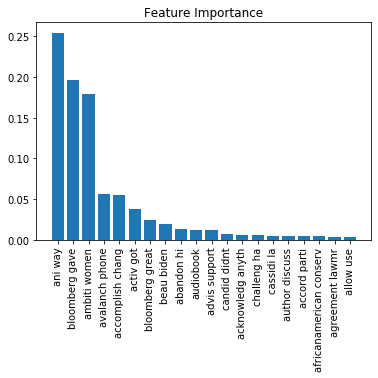

In [36]:
num_features = 20

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(num_features), importances[indices][0:num_features])

# Add feature names as x-axis labels
plt.xticks(range(num_features), names[0:num_features], rotation=90)

# Show plot
plt.show()

### 3.3.2 SVM Classifier 

In [40]:
# svm classifier
df_svm = pd.DataFrame({"config": [],
                   "accuracy": []})
best_config_svm = ["Best Configuration", "none", 0, "none", "none"]
for data in DTMs:
    print(data[0])
    print("")
    score = train_model(clf = svm_clf, dtm = data[1], test = data[2])
    print("======================================================")
    print("")
    if float(score) > float(best_config_svm[2]):
        best_config_svm = ["Best Configuration:", data[0], score, data[1], data[2]]
    df_svm = df_svm.append({"config": data[0],
               "accuracy": float(score)},
               ignore_index=True)

unigram, binary

Accuracy: 0.9963

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        90
           1       1.00      1.00      1.00        90
           2       0.99      1.00      0.99        90

   micro avg       1.00      1.00      1.00       270
   macro avg       1.00      1.00      1.00       270
weighted avg       1.00      1.00      1.00       270

Confusion Matrix:
[[89  0  1]
 [ 0 90  0]
 [ 0  0 90]]

bigram, binary

Accuracy: 0.9963

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        90
           1       1.00      1.00      1.00        90
           2       0.99      1.00      0.99        90

   micro avg       1.00      1.00      1.00       270
   macro avg       1.00      1.00      1.00       270
weighted avg       1.00      1.00      1.00       270

Confusion Matrix:
[[89  0  1]
 [ 0 90  0]
 [ 0  0 90]]

trigram, binary

Accuracy: 1.0000

              precisio

In [41]:
# results of svm classifier
df_svm

,config,accuracy
0,"unigram, binary",0.9963
1,"bigram, binary",0.9963
2,"trigram, binary",1.0000
3,"unigram, TF",0.9481
4,"bigram, TF",0.9667
5,"trigram, TF",0.9815
6,"unigram, TF-IDF",0.8259
7,"bigram, TF-IDF",0.7556
8,"trigram, TF-IDF",0.8185


In [42]:
# best model
print(best_config_svm)

['Best Configuration:', 'trigram, binary', '1.0000', <1080x120599 sparse matrix of type '<class 'numpy.int64'>'
	with 1006998 stored elements in Compressed Sparse Row format>, <270x120599 sparse matrix of type '<class 'numpy.int64'>'
	with 213614 stored elements in Compressed Sparse Row format>]
